In [1]:
import sqlalchemy as sa
import pandas as pd

import json
import logging
import requests

from sqlalchemy import inspect
from sqlalchemy.sql import text

In [2]:
def get_database_engine(environment: str):
    if environment == 'production':
        url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
        params = requests.get(url).json()['params']
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
        )
    
    elif environment == 'staging':
        with open('alerceread_db_staging.json', 'r', encoding='utf-8') as f:
            params = json.load(f)
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    else:
        raise ValueError(f'Environment "{environment}" not defined')
        
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print('Available Tables:\n', tables)
    return engine

In [3]:
ENVIRONMENT = "production"
engine = get_database_engine(environment=ENVIRONMENT)
engine.begin()

Available Tables:
 ['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [4]:
def preprocess_features_from_db(features: pd.DataFrame) -> pd.DataFrame:
    """features come from db in column format"""
    def fid_map(v):
        if v == 1:
            return "_1"  #'g'
        if v == 2:
            return "_2"  #'r'
        if v == 0:
            return ""
        
        if v == 12:
            return "_12"

    def normalize_name(v):
        return str(v).replace("-", "_").replace('/', '_')

    features_ = features.copy()
    features_["fid_name"] = features_["fid"].apply(lambda x: fid_map(x))
    features_["name"] = features_["name"] + features_["fid_name"]
    features_["name"] = features_["name"].apply(lambda x: normalize_name(x))
    features_ = features_[["oid", "name", "value"]]
    features_ = features_.pivot_table(
        index="oid", columns="name", values="value", aggfunc="first", dropna=False
    )

    return features_

In [5]:
import glob

oids = [oid.split('/')[-1].split('.')[0] for oid in glob.glob('db_production/data/*')]
#oids = [oids[0]]
oids = [f"'{oid}'" for oid in oids]
oids

["'ZTF17aacoobq'",
 "'ZTF18actbfbf'",
 "'ZTF17aabvxoe'",
 "'ZTF20aageyrd'",
 "'ZTF18acclctr'",
 "'ZTF18admpdys'",
 "'ZTF18aaadunf'",
 "'ZTF17aaagyhh'",
 "'ZTF22abiztag'",
 "'ZTF19acavpcq'",
 "'ZTF17aabwfmq'",
 "'ZTF18acrtzpo'",
 "'ZTF20aahmwdc'",
 "'ZTF18admfewi'",
 "'ZTF19aanqgpx'",
 "'ZTF17aabuyoa'",
 "'ZTF21abyrtsj'",
 "'ZTF23abscwjd'",
 "'ZTF19aalwfly'",
 "'ZTF18acsjity'",
 "'ZTF19aainmws'",
 "'ZTF18abmokgr'",
 "'ZTF18abuyqnw'",
 "'ZTF19aagmvlc'",
 "'ZTF18achckfp'",
 "'ZTF18aaadyyw'",
 "'ZTF18acbvsvv'",
 "'ZTF21acmwott'",
 "'ZTF21aakcnuk'",
 "'ZTF20acmgbds'",
 "'ZTF18abtsjog'",
 "'ZTF18aaadsbl'",
 "'ZTF17aabwfqr'",
 "'ZTF18acrfnjh'",
 "'ZTF18aczcffq'",
 "'ZTF18acbvrpy'",
 "'ZTF21acmpuqn'",
 "'ZTF21achyhzf'",
 "'ZTF20aarbzad'",
 "'ZTF19aalvzlx'",
 "'ZTF19acmgybn'",
 "'ZTF18aaadttd'",
 "'ZTF18acrumfa'",
 "'ZTF18acyuqxl'",
 "'ZTF18abxhofs'",
 "'ZTF18abxhoet'",
 "'ZTF20aafqudh'",
 "'ZTF20aafdvjk'",
 "'ZTF18acgmezv'",
 "'ZTF21aadokov'",
 "'ZTF19aagmuhn'",
 "'ZTF20aaekjfa'",
 "'ZTF22abpu

In [6]:
len(oids)

100

In [7]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.5.0';
                """

features = pd.read_sql_query(query_features, con=engine)
features = preprocess_features_from_db(features)
features

name,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaagyhh,0.316409,0.309808,1.000000,1.000000,1.0,1.0,0.327044,0.365517,0.0,0.0,...,1.000000,1.000000,15.083394,14.594233,1495.181488,800.321947,13.715539,4.090437,9.357354e-01,9.509671e-01
ZTF17aaahinf,0.600024,0.432720,1.000000,1.000000,1.0,1.0,0.487500,0.388350,0.0,0.0,...,0.531400,1.000000,16.578478,16.394721,289.085667,694.848322,0.136763,0.999667,1.167508e-01,8.780373e-10
ZTF17aaarvek,0.230988,0.218993,1.000000,1.000000,1.0,1.0,0.405034,0.454321,0.0,0.0,...,0.277149,0.999995,16.731932,15.670571,1983.684952,1233.766632,0.002665,18.471085,3.196195e-02,2.678936e-10
ZTF17aabuyoa,0.619639,0.441053,1.000000,1.000000,1.0,1.0,0.425837,0.435567,0.0,0.0,...,0.000253,0.517568,18.165204,17.277786,2198.928737,2050.102694,6.864093,0.995069,2.843445e-04,6.724024e-02
ZTF17aabvxoe,0.234099,0.221737,1.000000,1.000000,1.0,1.0,0.352941,0.419355,0.0,0.0,...,0.083431,1.000000,14.960351,14.419074,225.741039,831.207850,211.600441,3.039176,7.386241e-06,8.577218e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22abpujoh,0.089690,0.120265,0.381993,0.939787,1.0,1.0,0.309524,0.298507,0.0,0.0,...,0.999999,0.060807,18.697553,18.530954,610.813649,877.096151,66.751735,0.002594,3.133226e-04,5.336261e-01
ZTF22abybtmt,NaN,0.064967,NaN,0.723670,NaN,1.0,NaN,0.235294,NaN,0.0,...,1.000000,1.000000,19.058006,17.620424,760.800505,816.011074,0.482324,2.119831,2.884365e-07,5.549644e-07
ZTF23aabness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,14.296145,14.027384,655.449678,698.418726,59.631588,61.964096,1.480142e+00,1.062567e+00


### Obtener Detecciones y Fotometria Forzada

In [8]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
display(detections.head())
print(detections.shape)
print(detections.columns)

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF17aaagyhh,703270634415015008,58457.270637,2,703270634415,19.575300,1,703,84.400880,-15.417544,...,0.0179,NaN,14.363715,100.000000,0.006940,True,False,7.122954e+17,False,bulk_1.0.0
1,ZTF17aaagyhh,712295394415015113,58466.295394,1,712295394415,18.910126,1,712,84.400824,-15.417513,...,0.0404,306120144.0,14.838718,0.010558,0.014000,True,False,7.332102e+17,False,bulk_1.0.0
2,ZTF17aaagyhh,717271824415010095,58471.271829,2,717271824415,19.152456,-1,717,84.400784,-15.417624,...,0.0291,306120244.0,14.740381,100.000000,0.011560,True,False,7.332102e+17,False,bulk_1.0.0
3,ZTF17aaagyhh,727289224415010001,58481.289224,1,727289224415,19.964779,-1,727,84.400705,-15.417494,...,0.0202,306120144.0,15.394738,100.000000,0.013211,True,False,7.332102e+17,False,bulk_1.0.0
4,ZTF17aaagyhh,737194024415015002,58491.194028,1,737194024415,19.856300,1,737,84.400881,-15.417556,...,0.0211,NaN,14.870885,0.011813,0.015140,True,False,7.522501e+17,False,bulk_1.0.0


(27023, 30)
Index(['oid', 'candid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')


In [9]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
display(forced_photometry.head())
print(forced_photometry.shape)
print(forced_photometry.columns)

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2530217185015,ZTF18abmrxgg,60284.217188,1,52.75594,64.497422,None,None,22.480440,1.158725,...,20.364799,1,0,0.305711,52.755898,64.497505,17.917000,0.018,0.791,-0.009
1,2509436186215,ZTF18abmrxgg,60263.436181,2,52.75594,64.497422,None,None,18.584002,0.035797,...,20.282499,1,0,0.154826,52.755886,64.497459,16.978001,0.025,1.160,-0.089
2,2507431666215,ZTF18abmrxgg,60261.431667,1,52.75594,64.497422,None,None,20.256533,0.143250,...,20.315701,1,0,0.182710,52.755898,64.497467,18.011000,0.028,1.370,-0.100
3,2507267266215,ZTF18abmrxgg,60261.267268,2,52.75594,64.497422,None,None,18.928444,0.050106,...,20.156799,1,0,0.154826,52.755886,64.497459,16.978001,0.025,1.160,-0.089
4,2505406726215,ZTF18abmrxgg,60259.406725,1,52.75594,64.497422,None,None,20.005064,0.136611,...,20.089300,1,0,0.182710,52.755898,64.497467,18.011000,0.028,1.370,-0.100


(11212, 42)
Index(['pid', 'oid', 'mjd', 'fid', 'ra', 'dec', 'e_ra', 'e_dec', 'mag',
       'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos',
       'corrected', 'dubious', 'parent_candid', 'has_stamp', 'field', 'rcid',
       'rfid', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'magzpsci',
       'magzpsciunc', 'magzpscirms', 'clrcoeff', 'clrcounc', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'programid', 'procstatus',
       'distnr', 'ranr', 'decnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr'],
      dtype='object')


In [11]:
import numpy as np

mag_corr_column = "magpsf_corr"
e_mag_corr_ext_column = "sigmapsf_corr_ext"
diff_mag_column = "magpsf"
e_diff_mag_column = "sigmapsf"
mag_corr_column_fp = "mag_corr"
e_mag_corr_ext_column_fp = "e_mag_corr_ext"
diff_mag_column_fp = "mag"
e_diff_mag_column_fp = "e_mag"
w1_column = "w1mpro"
w2_column = "w2mpro"
w3_column = "w3mpro"
w4_column = "w4mpro"


detection_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column,
    e_mag_corr_ext_column,
    diff_mag_column,
    e_diff_mag_column,
    "fid",
    "isdiffpos",
]

forced_photometry_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column_fp,
    e_mag_corr_ext_column_fp,
    diff_mag_column_fp,
    e_diff_mag_column_fp,
    "fid",
    "isdiffpos",
]

def mag2flux(mag):
    return 10 ** (-(mag - 23.9) / 2.5)

def mag_err_2_flux_err(mag_err, mag):
    return np.log(10.0) * mag2flux(mag) / 2.5 * mag_err

def recover_mag_and_emag_with_signed_flux(df):
    df["isdiffpos"] = np.sign(df["fluxdiff_uJy"]).astype(int)
    df["mag"] = -2.5 * np.log10(np.abs(df["fluxdiff_uJy"])) + 23.9
    df["e_mag"] = df["fluxerrdiff_uJy"] / np.abs(df["fluxdiff_uJy"])
    df.loc[df["fluxdiff_uJy"] == 0, ["mag", "e_mag"]] = np.nan
    return df

def get_det_AO_to_InputDTO(lightcurve):
    detections = lightcurve.copy()
    detections = detections[detections.unit == "diff_flux"].rename(
        columns={
            "brightness": "fluxdiff_uJy",
            "e_brightness": "fluxerrdiff_uJy",
        }
    )
    detections = recover_mag_and_emag_with_signed_flux(detections)
    return detections

def preprocess_detections_from_db(detections: pd.DataFrame) -> pd.DataFrame:

    detections_ = detections.copy()
    detections_.fillna(value=np.nan, inplace=True)
    detections_["forced"] = False
    detections_["unit"] = "diff_flux"

    detections_.rename(
        columns={
            mag_corr_column: "mag_corr",
            e_mag_corr_ext_column: "e_mag_corr_ext", # sigmapsf_corr_ext
            diff_mag_column: "mag",
            e_diff_mag_column: "e_mag",
        },
        inplace=True,
    )

    detections_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    detections_["brightness"] = mag2flux(detections_["mag"]) * detections_["isdiffpos"]
    detections_["e_brightness"] = mag_err_2_flux_err(
        detections_["e_mag"], detections_["mag"]
    )
    return detections_

def preprocess_forced_photometry_from_db(
    forced_photometry: pd.DataFrame,
) -> pd.DataFrame:

    forced_photometry_ = forced_photometry.copy()
    forced_photometry_.fillna(value=np.nan, inplace=True)
    forced_photometry_["unit"] = "diff_flux"
    forced_photometry_.rename(
        columns={
            mag_corr_column_fp: "mag_corr",
            e_mag_corr_ext_column_fp: "e_mag_corr_ext",
            diff_mag_column_fp: "mag",
            e_diff_mag_column_fp: "e_mag",
        },
        inplace=True,
    )

    forced_photometry_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    forced_photometry_["brightness"] = (
        mag2flux(forced_photometry_["mag"]) * forced_photometry_["isdiffpos"]
    )
    forced_photometry_["e_brightness"] = mag_err_2_flux_err(
        forced_photometry_["e_mag"], forced_photometry_["mag"]
    )

    forced_photometry_["candid"] = forced_photometry_["oid"].astype(str) + forced_photometry_["pid"].astype(str) 

    return forced_photometry_

def preprocess_detections_and_forced_photometry_from_db(
    detections: pd.DataFrame, forced_photometry: pd.DataFrame
) -> pd.DataFrame:
    columns = ['oid', 'mjd']
    detections_and_forced_photometry = pd.concat(
        [
            preprocess_detections_from_db(detections),
            preprocess_forced_photometry_from_db(forced_photometry),
        ]
    )

    detections_and_forced_photometry = get_det_AO_to_InputDTO(detections_and_forced_photometry)
    detections_and_forced_photometry.drop_duplicates(["candid", "oid"], inplace=True)
    detections_and_forced_photometry.sort_values(
        by=["mjd", "forced"], ascending=[True, False], inplace=True
    )
    detections_and_forced_photometry.set_index("oid", inplace=True)
    return detections_and_forced_photometry

In [12]:
detections_and_ff = preprocess_detections_and_forced_photometry_from_db(detections, forced_photometry)
detections_and_ff

/tmp/ipykernel_2780749/1220885348.py:104: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forced_photometry_.fillna(value=np.nan, inplace=True)


,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,mag,...,adpctdif1,adpctdif2,programid,procstatus,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aabuyoa,586499515315015002,58340.499514,1,586499515315,19.825830,1,586.0,47.842236,65.270285,19.158382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF17aaarvek,589446625115010011,58343.446620,1,589446625115,20.536488,-1,589.0,67.065478,49.858095,18.537380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18abmokgr,589446623915015043,58343.446620,1,589446623915,20.685637,1,589.0,64.744883,48.224003,19.156536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18abmrxgg,590406565015015014,58344.406563,1,590406565015,20.634188,1,590.0,52.755968,64.497456,19.640730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aabfgsb,590492921815010002,58344.492928,1,590492921815,20.591742,-1,590.0,65.315806,46.716245,19.172075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aakrppt,ZTF19aakrppt3001235126315,60755.235127,1,3001235126315,19.505501,-1,NaN,124.297428,-21.969766,17.370489,...,0.063577,0.076794,1.0,0,124.297501,-21.969713,15.580,0.013,0.877,-0.024
ZTF19aagmvlc,ZTF19aagmvlc3001235122415,60755.235127,1,3001235122415,19.413700,1,NaN,126.156223,-24.456369,18.901846,...,0.061655,0.078240,1.0,0,126.156189,-24.456310,17.063,0.014,1.001,0.013
ZTF19aagmvlc,3001251872415015002,60755.251875,2,3001251872415,19.011032,1,3001.0,126.156223,-24.456369,18.248606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from alerce_classifiers.base.dto import InputDTO
from alerce_classifiers.base._types import *

input_dto = InputDTO(
        Detections(detections_and_ff),
        NonDetections(pd.DataFrame()),
        Features(pd.DataFrame(features)),
        Xmatch(pd.DataFrame()),
        Stamps(pd.DataFrame()),
    )

In [14]:
from alerce_classifiers.mbappe.mapper import MbappeMapper
from alerce_classifiers.mbappe.model import MbappeClassifier

MBAPPE_MODEL_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/model.ckpt"
MBAPPE_QUANTILES_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/quantiles"
MBAPPE_CONFIG_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/configs"

model = MbappeClassifier(
    model_path=MBAPPE_MODEL_PATH,
    quantiles_dir=MBAPPE_QUANTILES_PATH,
    config_dir=MBAPPE_CONFIG_PATH,
    mapper=MbappeMapper(),
)

predictions = model.predict(input_dto)
df_local_mbappe = predictions.probabilities
df_local_mbappe = df_local_mbappe.reset_index()
df_local_mbappe = df_local_mbappe.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_mbappe['ranking'] = df_local_mbappe.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_mbappe

/home/dmoreno/miniconda3/envs/alerce_last_v1/lib/python3.10/site-packages/alerce_classifiers/mbappe/mapper.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["md_cols"]] = quantiles["quantile_md"].transform(
/home/dmoreno/miniconda3/envs/alerce_last_v1/lib/python3.10/site-packages/alerce_classifiers/mbappe/mapper.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["feat_cols"]] = quantiles[


,oid,class_name,probability,ranking
0,ZTF17aaagyhh,CEP,3.917224e-03,7
1,ZTF17aaahinf,CEP,9.779886e-03,2
2,ZTF17aaarvek,CEP,2.117577e-02,4
3,ZTF17aabuyoa,CEP,4.439538e-03,3
4,ZTF17aabvxoe,CEP,2.981145e-02,5
...,...,...,...,...
2173,ZTF22abpujoh,TDE,2.180039e-11,21
2174,ZTF22abybtmt,TDE,9.007294e-08,21
2175,ZTF23aabness,TDE,1.449734e-08,20
2176,ZTF23abscwjd,TDE,1.948245e-07,18


In [15]:
query_to_prod_atat = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
                    and classifier_version = '0.3.6';
        """
df_prod_mbappe = pd.read_sql_query(query_to_prod_atat, con=engine)
df_prod_mbappe

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF17aaagyhh,LC_classifier_ATAT_forced_phot(beta),0.3.6,AGN,5.156743e-07,12
1,ZTF17aaagyhh,LC_classifier_ATAT_forced_phot(beta),0.3.6,Blazar,3.351922e-08,16
2,ZTF17aaagyhh,LC_classifier_ATAT_forced_phot(beta),0.3.6,CEP,2.554960e-02,5
3,ZTF17aaagyhh,LC_classifier_ATAT_forced_phot(beta),0.3.6,CV/Nova,9.477921e-05,9
4,ZTF17aaagyhh,LC_classifier_ATAT_forced_phot(beta),0.3.6,DSCT,2.253702e-02,6
...,...,...,...,...,...,...
2063,ZTF23abscwjd,LC_classifier_ATAT_forced_phot(beta),0.3.6,SNII,6.514134e-06,16
2064,ZTF23abscwjd,LC_classifier_ATAT_forced_phot(beta),0.3.6,SNIIb,1.578131e-10,21
2065,ZTF23abscwjd,LC_classifier_ATAT_forced_phot(beta),0.3.6,SNIIn,1.039889e-13,22
2066,ZTF23abscwjd,LC_classifier_ATAT_forced_phot(beta),0.3.6,TDE,3.411413e-10,20


In [16]:
df_mbappe = df_local_mbappe.merge(df_prod_mbappe, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_mbappe

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF17aaagyhh,CEP,3.917224e-03,7,LC_classifier_ATAT_forced_phot(beta),0.3.6,2.554960e-02,5
1,ZTF17aaahinf,CEP,9.779886e-03,2,LC_classifier_ATAT_forced_phot(beta),0.3.6,2.986828e-02,2
2,ZTF17aaarvek,CEP,2.117577e-02,4,LC_classifier_ATAT_forced_phot(beta),0.3.6,2.633878e-01,2
3,ZTF17aabuyoa,CEP,4.439538e-03,3,LC_classifier_ATAT_forced_phot(beta),0.3.6,1.786127e-02,2
4,ZTF17aabvxoe,CEP,2.981145e-02,5,LC_classifier_ATAT_forced_phot(beta),0.3.6,1.831706e-02,6
...,...,...,...,...,...,...,...,...
2063,ZTF22abillrz,TDE,5.557101e-15,22,LC_classifier_ATAT_forced_phot(beta),0.3.6,5.012893e-12,20
2064,ZTF22abiztag,TDE,9.984860e-12,22,LC_classifier_ATAT_forced_phot(beta),0.3.6,4.672616e-10,20
2065,ZTF22abpujoh,TDE,2.180039e-11,21,LC_classifier_ATAT_forced_phot(beta),0.3.6,4.840688e-06,18
2066,ZTF22abybtmt,TDE,9.007294e-08,21,LC_classifier_ATAT_forced_phot(beta),0.3.6,4.046839e-05,20


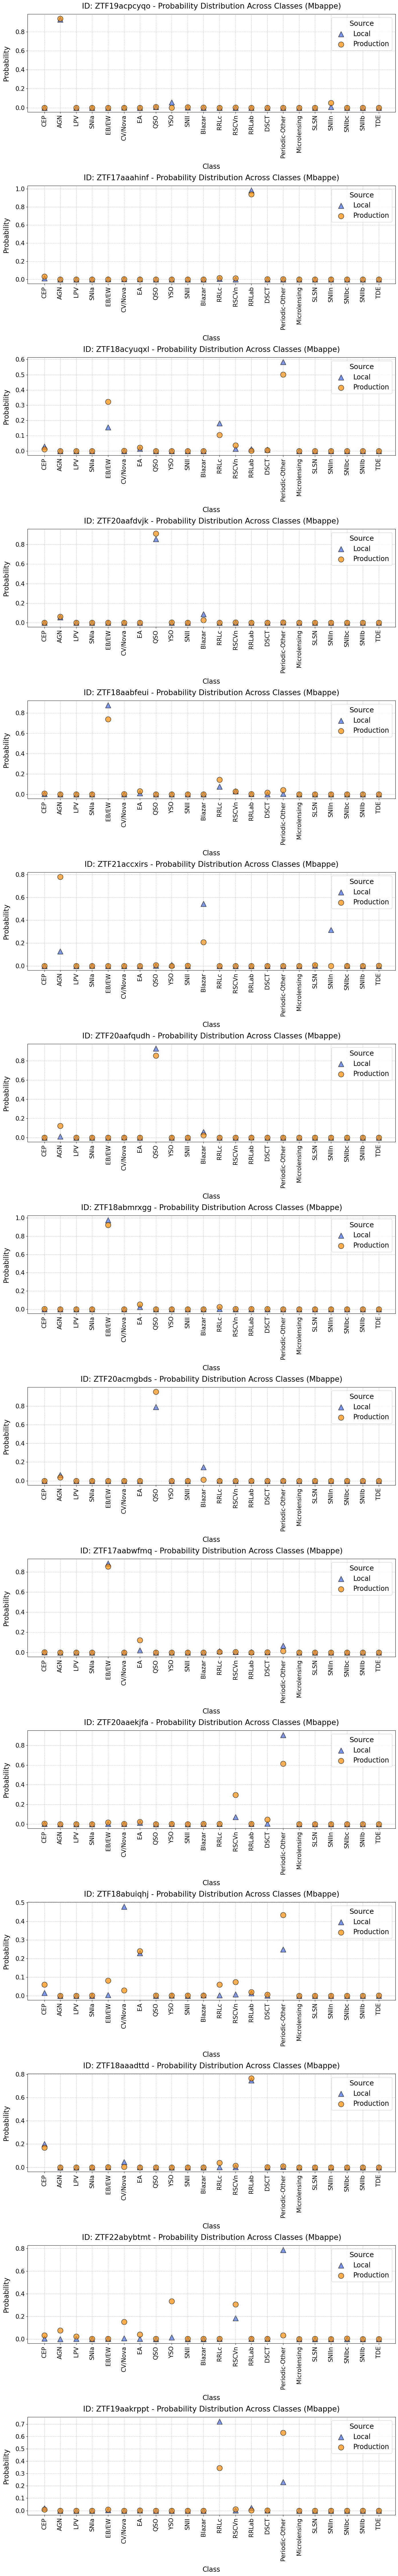

In [20]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

unique_oids = df_mbappe['oid'].unique() #sorted()
num_selected_oids = min(15, len(unique_oids))  # Asegurar que no seleccionamos más de los disponibles
selected_oids = np.random.choice(unique_oids, num_selected_oids, replace=False)
#selected_oids = unique_oids[:15]

# Crear la figura con subplots dinámicos
fig, axes = plt.subplots(num_selected_oids, 1, figsize=(14, 6 * num_selected_oids))

# Si hay un solo objeto, convertir `axes` en una lista para iterar
if num_selected_oids == 1:
    axes = [axes]

# Iterar sobre los oids seleccionados
for ax, oid in zip(axes, selected_oids):
    df_oid = df_mbappe[df_mbappe['oid'] == oid]
    
    # Convertir las clases en valores numéricos
    class_labels = df_oid['class_name'].unique()
    class_to_x = {cls: i for i, cls in enumerate(class_labels)}
    df_oid = df_oid.copy()  # Create an explicit copy
    df_oid.loc[:, 'class_x'] = df_oid['class_name'].map(class_to_x)

    # Graficar datos de Local
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_local'],
        color=color_local,
        marker="^",
        s=180,
        label="Local",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Graficar datos de Producción
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_prod'],
        color=color_prod,
        marker="o",
        s=180,
        label="Production",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Personalizar etiquetas y diseño
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=90, fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)

    ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
    ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
    
    # Título con ID del objeto
    ax.set_title(f'ID: {oid} - Probability Distribution Across Classes (Mbappe)', fontsize=fs+4, pad=14, color='black')
    
    ax.legend(fontsize=fs+2, title="Source", title_fontsize=fs+3)
    ax.grid(True, linestyle="--", alpha=0.7)

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()
